<a href="https://colab.research.google.com/github/kimjh0607/DL_TeamProject/blob/main/InceptionV3_LSTM_English.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !nvidia-smi

In [2]:
!pip install kaggle --quiet

In [3]:
!pip install torchtext==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.7 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.16.0
    Uninstalling torchtext-0.16.0:
      Successfully uninstalled torchtext-0.16.0


In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
path = '/content/drive/MyDrive/ColabNotebooks/credential/kaggle.json'

In [6]:
!mkdir ~/.kaggle
!cp {path} ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d aladdinpersson/flickr8kimagescaptions
# !kaggle datasets download -d eeshawn/flickr30k

100% 1.03G/1.04G [00:34<00:00, 27.9MB/s]
100% 1.04G/1.04G [00:34<00:00, 32.6MB/s]


In [8]:
import zipfile
zip_file = "flickr8kimagescaptions.zip"
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("dataset")
print("Unzipped the dataset.")
drive.flush_and_unmount()
print("Google Drive unmounted.")

Unzipped the dataset.
Google Drive unmounted.


In [ ]:
# import os

# # Print the current working directory
# print("Current working directory:", os.getcwd())

# # List files in the current working directory
# print("Files in the current working directory:")
# os.listdir()

## image resize

In [9]:
import os
from PIL import Image

image_dir = './dataset/flickr8k/images'
train_image_dir = './resized_train/images'
val_image_dir = './resized_val/images'
test_image_dir = './resized_test/images'
size = [256, 256]

def resize_image(image, size): # resize 함수
  return image.resize(size, Image.ANTIALIAS)

if not os.path.exists(train_image_dir):
  os.makedirs(train_image_dir)
if not os.path.exists(val_image_dir):
  os.makedirs(val_image_dir)
if not os.path.exists(test_image_dir):
  os.makedirs(test_image_dir)

In [10]:
image_dir

'./dataset/flickr8k/images'

In [11]:
images = sorted(os.listdir(image_dir))
num_images = len(images)
num_train_images = 6000
num_val_images = 1000

In [12]:
for i, image in enumerate(images):
  if (i+1) <= num_train_images:
      output_dir = train_image_dir
  elif (i+1) <= num_train_images + num_val_images:
    output_dir = val_image_dir
  else:
    output_dir = test_image_dir

  with open(os.path.join(image_dir, image), 'rb+') as f:
    with Image.open(f) as img:
      img = resize_image(img, size)
      img.save(os.path.join(output_dir, image), img.format)
  if (i+1) % 1000 == 0:
    print(f'[{i+1}/{num_images}] Resize and save {output_dir}')

<ipython-input-9-613eeb6403ea>:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  return image.resize(size, Image.ANTIALIAS)


[1000/8091] Resize and save ./resized_train/images
[2000/8091] Resize and save ./resized_train/images
[3000/8091] Resize and save ./resized_train/images
[4000/8091] Resize and save ./resized_train/images
[5000/8091] Resize and save ./resized_train/images
[6000/8091] Resize and save ./resized_train/images
[7000/8091] Resize and save ./resized_val/images
[8000/8091] Resize and save ./resized_test/images


In [13]:
import pickle
import nltk
from collections import Counter

nltk.download('punkt')

caption_path = './dataset/flickr8k/captions.txt'
vocab_path = './vocab.pkl'
word_threshold = 4
train_caption_path = './resized_train/captions.txt'
val_caption_path = './resized_val/captions.txt'
test_caption_path = './resized_test/captions.txt'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [14]:
class Vocabulary(object):
  def __init__(self):
    self.word2idx = {}
    self.idx2word = {}
    self.idx = 0

  def add_word(self, word):
    if not word in self.word2idx:
      self.word2idx[word] = self.idx
      self.idx2word[self.idx] = word
      self.idx += 1

  def __call__(self, word):
    if not word in self.word2idx:
      return self.word2idx['<unk>']
    return self.word2idx[word]

  def __len__(self):
    return len(self.word2idx)

counter = Counter()

with open(caption_path, 'r') as f:
  lines = sorted(f.readlines()[1:])
  for i in range(len(lines)):
    line = lines[i]
    if (i+1) <= num_train_images * 5:
      output_caption = train_caption_path
    elif (i+1) <= (num_train_images + num_val_images) * 5:
      output_caption = val_caption_path
    else:
      output_caption = test_caption_path

    index = line.find(",")
    caption = line[index+1:]
    tokens = nltk.tokenize.word_tokenize(caption.lower())
    counter.update(tokens)
    with open(output_caption, 'a') as output_caption_f:
      output_caption_f.write(line)


In [15]:
words = []
for word, cnt in counter.items():
  if cnt >= word_threshold:
    words.append(word)

In [16]:
vocab = Vocabulary()
vocab.add_word('<pad>')
vocab.add_word('<start>')
vocab.add_word('<end>')
vocab.add_word('<unk>')

for word in words:
  vocab.add_word(word)

with open(vocab_path, 'wb') as f:
  pickle.dump(vocab, f)

In [17]:
# 각 데이터 셋 캡션 수 확인 가능
!wc -l ./resized_train/captions.txt

!wc -l ./resized_val/captions.txt

!wc -l ./resized_test/captions.txt

30000 ./resized_train/captions.txt
5000 ./resized_val/captions.txt
5455 ./resized_test/captions.txt


---
# flickr8k, custom dataset class 정의

In [18]:
import torch.utils.data as data

class Flickr8kDataset(data.Dataset):
  def __init__(self, root, captions, vocab, transform=None):
    self.root=root
    with open(captions, 'r') as f:
      lines = f.readlines()
      self.captions = []
      for line in lines:
        index = line.find(',')
        path = line[:index]
        caption = line[index+1:]
        self.captions.append((path, caption))
    self.vocab=vocab
    self.transform=transform

  def __getitem__(self, index):
    vocab = self.vocab
    path = self.captions[index][0]
    caption = self.captions[index][1]

    image = Image.open(os.path.join(self.root, path)).convert('RGB')
    if self.transform is not None:
      image = self.transform(image)

    tokens = nltk.tokenize.word_tokenize(caption.lower())
    caption = []
    caption.append(vocab('<start>'))
    caption.extend([vocab(token) for token in tokens])
    caption.append(vocab('<end>'))
    target = torch.Tensor(caption)

    return image, target

  def __len__(self):
    return len(self.captions)


In [19]:
def collate_fn(data):
  data.sort(key=lambda x: len(x[1]), reverse=True)
  images, captions = zip(*data)

  images = torch.stack(images, 0)

  lengths = [len(caption) for caption in captions]
  targets = torch.zeros(len(captions), max(lengths)).long()

  for i, cap in enumerate(captions):
    end = lengths[i]
    targets[i, :end] = cap[:end]

  return images, targets, lengths

def collate_fn_test(data):
  images, captions = zip(*data)
  images = torch.stack(images, 0)
  lengths = [len(caption) for caption in captions]
  targets = torch.zeros(len(captions), max(lengths)).long()

  for i, cap in enumerate(captions):
    end = lengths[i]
    targets[i, :end] = cap[:end]

  return images, targets, lengths

In [20]:
def get_loader(root, captions, vocab, transform, batch_size, shuffle, num_workers, testing):
  flickr8k = Flickr8kDataset(root=root, captions=captions, vocab=vocab, transform=transform)
  if not testing:
        data_loader = torch.utils.data.DataLoader(dataset=flickr8k, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=collate_fn)
  else:
        data_loader = torch.utils.data.DataLoader(dataset=flickr8k, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=collate_fn_test)
  return data_loader

In [70]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision.models.inception import InceptionOutputs

class EncoderCNN(nn.Module):
  def __init__(self, embed_size):
    super(EncoderCNN, self).__init__()
    inception = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
    # modules = list(inception.children())[:-1]
    # 마지막 fully connected 레이어 제거
    inception.fc = nn.Identity()

    self.inception = inception
    self.linear = nn.Linear(2048, embed_size)
    self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

  def forward(self, images):
    # with torch.no_grad():
    #   features = self.inception(images)
    features = self.inception(images)
    if isinstance(features, InceptionOutputs):
      features = features.logits
    # features = self.inception(image)
    feature = features.view(features.size(0), -1)
    features = self.bn(self.linear(features))
    return features

class DecoderRNN(nn.Module):
  def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
    super(DecoderRNN, self).__init__()
    self.embed = nn.Embedding(vocab_size, embed_size)
    self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
    self.linear = nn.Linear(hidden_size, vocab_size)
    self.max_seg_length = max_seq_length

  def forward(self, features, captions, lengths):
    embeddings = self.embed(captions)
    embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
    packed = pack_padded_sequence(embeddings, lengths, batch_first=True)
    hiddens, _ = self.lstm(packed)
    outputs = self.linear(hiddens[0])
    return outputs

  def sample(self, features, states=None):
    sampled_indexes = []
    inputs = features.unsqueeze(1)
    for i in range(self.max_seg_length):
      hiddens, states = self.lstm(inputs, states)
      outputs = self.linear(hiddens.squeeze(1))
      _, predicted = outputs.max(1)
      sampled_indexes.append(predicted)
      inputs = self.embed(predicted)
      inputs = inputs.unsqueeze(1)
    sampled_indexes = torch.stack(sampled_indexes, 1)

    return sampled_indexes


In [71]:
import torch
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_path = 'models/'
crop_size = 299
vocab_path = './vocab.pkl'

if not os.path.exists(model_path):
  os.makedirs(model_path)

with open(vocab_path, 'rb') as f:
  vocab = pickle.load(f)

train_transform = transforms.Compose([
    transforms.RandomCrop(crop_size, pad_if_needed=True),
    transforms.Resize(299),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229,0.224,0.225))
])

val_transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229,0.224,0.225))
])

test_transform = transforms.Compose([
    transforms.Resize(crop_size),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229,0.224,0.225))
])

batch_size = 128
num_workers = 2

train_data_loader = get_loader(train_image_dir, train_caption_path, vocab, train_transform, batch_size, shuffle=True, num_workers=num_workers, testing=False)
val_data_loader = get_loader(val_image_dir, val_caption_path, vocab, val_transform, batch_size, shuffle=False, num_workers=num_workers, testing=False)
test_data_loader = get_loader(test_image_dir, test_caption_path, vocab, test_transform, batch_size, shuffle=False, num_workers=num_workers, testing=True)

In [72]:
embed_size = 256
hidden_size = 1024
num_layers = 1

encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

num_epochs = 5
learning_rate = 0.00001

log_step = 20
save_step = 1000

criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [73]:
# 데이터 로더에서 이미지 배치 하나 추출
images, _, _ = next(iter(train_data_loader))
images = images.to(device)

# Encoder를 통해 이미지 특성 추출
with torch.no_grad():
    features = encoder(images)

# 추출된 특성 확인
print("Features shape:", features.shape)



Features shape: torch.Size([128, 256])


In [74]:
import time
import numpy as np

start_time = time.time()

for epoch in range(num_epochs):
  print('[>>Training<<]')
  total_loss = 0
  total_count = 0
  total_step = len(train_data_loader)

  for i, (images, captions, lengths) in enumerate(train_data_loader):
    images = images.to(device)
    captions = captions.to(device)
    targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

    features = encoder(images)
    outputs = decoder(features, captions, lengths)
    loss = criterion(outputs, targets)

    decoder.zero_grad()
    encoder.zero_grad()

    loss.backward()
    optimizer.step()

    total_loss = total_loss + loss.item()
    total_count = images.shape[0]

    if i % log_step == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Step[{i}/{total_step}], Avg Loss:{(total_loss / total_count):.4f}, Perplexity:{np.exp(loss.item()):5.4f}, Elapsed time:{time.time() - start_time:.4f}s')

  torch.save(decoder.state_dict(), os.path.join(model_path, f'decoder-{epoch+1}.ckpt'))
  torch.save(encoder.state_dict(), os.path.join(model_path, f'encoder-{epoch+1}.ckpt'))
  print(f'Model saved : {os.path.join(model_path, f"decoder-{epoch+1}.ckpt")}')
  print(f'Model saved : {os.path.join(model_path, f"encoder-{epoch+1}.ckpt")}')

  print('[>>Validation<<]')
  total_loss = 0
  total_count = 0
  total_step = len(val_data_loader)

  with torch.no_grad():
    for i, (images, captions, lengths) in enumerate(val_data_loader):
      images = images.to(device)
      captions = captions.to(device)
      targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

      features = encoder(images)
      outputs = decoder(features, captions, lengths)
      loss = criterion(outputs, targets)

      total_loss = total_loss + loss.item()
      total_count = total_count + images.shape[0]

      if i % log_step == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i}/{total_step}], Average Loss: {(total_loss / total_count):.4f}, Perplexity: {np.exp(loss.item()):5.4f}, Elapsed time: {time.time() - start_time:.4f}s')



[>>Training<<]
Epoch [1/5], Step[0/235], Avg Loss:0.0636, Perplexity:3445.4366, Elapsed time:2.5599s
Epoch [1/5], Step[20/235], Avg Loss:1.3340, Perplexity:3354.2575, Elapsed time:38.8086s
Epoch [1/5], Step[40/235], Avg Loss:2.6000, Perplexity:3256.6714, Elapsed time:75.3747s
Epoch [1/5], Step[60/235], Avg Loss:3.8610, Perplexity:3147.8256, Elapsed time:111.6196s
Epoch [1/5], Step[80/235], Avg Loss:5.1169, Perplexity:3047.7841, Elapsed time:148.0712s
Epoch [1/5], Step[100/235], Avg Loss:6.3663, Perplexity:2902.7005, Elapsed time:184.4592s
Epoch [1/5], Step[120/235], Avg Loss:7.6080, Perplexity:2745.9462, Elapsed time:220.8984s
Epoch [1/5], Step[140/235], Avg Loss:8.8366, Perplexity:2412.9209, Elapsed time:257.3146s
Epoch [1/5], Step[160/235], Avg Loss:10.0274, Perplexity:1575.6384, Elapsed time:293.7405s
Epoch [1/5], Step[180/235], Avg Loss:11.1137, Perplexity:732.9642, Elapsed time:330.1952s
Epoch [1/5], Step[200/235], Avg Loss:12.0998, Perplexity:445.4032, Elapsed time:366.5928s
Epoc

In [ ]:
# from google.colab import files
# files.download('models/encoder-5.ckpt')
# files.download('models/decoder-5.ckpt')

In [ ]:
# !wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ERnDZFI8KD9OrX8rZGB4zucBLL1C2OQl5zdEIj9M23VH8A?download=1 -O nic_encoder_ResNet101.ckpt
# !wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EfpMfIRuTy1NndX8U7C70XMBmu6wd3JofEo5T-uyIP8YOA?download=1 -O nic_decoder_ResNet101.ckpt


In [91]:
def load_image(image_path, transform=None):
  image = Image.open(image_path).convert('RGB')
  image = image.resize([299, 299], Image.LANCZOS)

  if transform is not None:
    image = transform(image).unsqueeze(0)
  return image

image_path = '/content/resized_test/images/3724623861_2bb6c23641.jpg'
encoder_path = '/content/models/encoder-5.ckpt'
decoder_path = '/content/models/decoder-5.ckpt'
vocab_path = './vocab.pkl'

embed_size = 256
hidden_size = 1024
num_layers = 1

In [92]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

with open(vocab_path, 'rb') as f:
  vocab = pickle.load(f)

encoder = EncoderCNN(embed_size).eval()
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
encoder = encoder.to(device)
decoder = decoder.to(device)

encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

image = load_image(image_path, transform)
image_tensor = image.to(device)

feature = encoder(image_tensor)
sampled_ids = decoder.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()

sampled_caption = []
for word_id in sampled_ids:
  word = vocab.idx2word[word_id]
  sampled_caption.append(word)
  if word == '<end>':
    break
sentence = ' '.join(sampled_caption)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


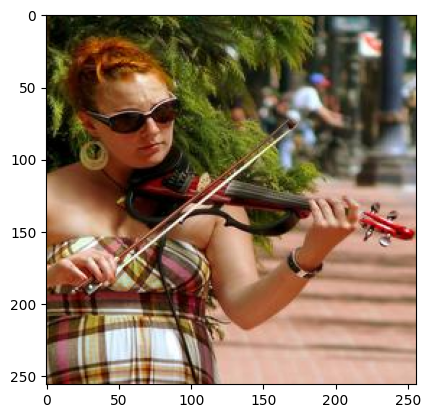

mats greenhouse waiter sparring fields opponents a man in a man in a <unk> . <end>


In [93]:
import matplotlib.pyplot as plt

image = Image.open(image_path)
plt.imshow(np.asarray(image))
plt.show()
print(sentence)